In [1]:
%matplotlib inline
%timeit
import sys
sys.path.append('pymodules')
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer

# this class read the raw input and tokenizes comprehensively for use with modeling
import pymodules.read_and_tokenize as contacts_utils

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, mean_squared_error

#from sklearn.metrics import multilabel_confusion_matrix, f1_score
## multiprocessing
#import multiprocess as mp
## not sure if this is needed, although used below ...
#from keras.utils import to_categorical
## from https://stackoverflow.com/questions/7370801/how-do-i-measure-elapsed-time-in-python

from timeit import default_timer as timer

/Users/bmukund/miniconda3/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
[nltk_data] Downloading package wordnet to /Users/bmukund/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/bmukund/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
filename = "data/Master-data_Q42021.xlsx"
prep_comments, df = contacts_utils.read_file(filename)

Columns dropped: ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'PRODUCT_LINK', 'WEBSITE']
Read sheet 'Scrubbed_data' ...
 Drop the Author column and replace it with gender of author ...
Consolidate all the comments into one column called COMMENT
Make ratings into integers
Tokenize data based on regex found from experimentation and common usage ...
Comments before tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments after tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments at index[0] before basic cleaning:
 Acucue 2 Contact Lenses I have used these lenses for a lon

### Vectorization
* TF-IDF weights more words that occur frequently but in lesser number of documents. This seems to skew ranking towards advertisement like reviews. In any case for SVM, we use the count of tokens to establish a baseline accuracy of model, prior to using RNN model.

In [3]:
# simple auxiliary function to override the preprocessing done by sklearn
def do_nothing(doc):
    return doc

# create a CountVectorizer object using our preprocessed text
# uni gram
count_vectorizer = CountVectorizer(encoding='utf-8',
                                   preprocessor=do_nothing,  # apply no additional preprocessing
                                   tokenizer=do_nothing,     # apply no additional tokenization
                                   lowercase=False,
                                   strip_accents=None,
                                   stop_words=None,
                                   ngram_range=(1, 1),       # generate only unigrams
                                   analyzer='word',          # analysis at the word-level
                                   max_df=0.5,              # ignore tokens that have a higher document frequency (can be int or percent)
                                   min_df=500,                # ignore tokens that have a lowe document frequency (can be int or percent)
                                   max_features=None,        # we could impose a maximum number of vocabulary terms
                                   )


In [4]:
# transform our preprocessed tokens into a document-term matrix
dt_matrix = count_vectorizer.fit_transform(prep_comments.tokens)
print(f"Document-term matrix created with shape: {dt_matrix.shape}")


Document-term matrix created with shape: (8794, 18)


In [5]:
# we can access a dictionary that maps between words and positions of the document-term matrix. We need this for SVM in order to make the word itself as column of dataframe (see output)
id_word_indexer = pd.DataFrame(count_vectorizer.vocabulary_.items())
id_word_indexer

,0,1
0,contact,1
1,lenses,10
2,service,15
3,lens,9
4,great,8
5,comfortable,0
6,easy,4
7,product,14
8,years,17
9,fast,6


In [6]:
## FOR SVM, we need to make a matrix with proper column names
# Also, we need another column that denotes the review
# We also need to normalize the data
df_svm = pd.DataFrame(dt_matrix.toarray())
df_svm.rename(columns=id_word_indexer.to_dict()[0], inplace=True)
df_svm

,contact,lenses,service,lens,great,comfortable,easy,product,years,fast,contacts,day,pack,eyes,love,good,price,wear
0,0,1,0,0,0,0,0,0,2,1,3,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8789,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
8790,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
8791,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8792,0,1,2,0,0,3,0,0,0,0,2,0,0,1,1,0,0,1


In [7]:
# attach sentiment, seems
def find_sentiment(rating):
    choices = [0, 1, 2]
    conditions = [rating < 3, rating == 3, rating > 3]
    senti = np.select(conditions, choices)
    return senti

SENTIMENT_SERIES = df['RATING'].apply(find_sentiment).astype('category')
df_svm['_SENTIMENT_'] = SENTIMENT_SERIES.values
df_svm['_SENTIMENT_'] = df_svm['_SENTIMENT_'].astype('category')
df_svm._SENTIMENT_.value_counts()

2    8386
0     336
1      72
Name: _SENTIMENT_, dtype: int64

In [8]:
X = df_svm.drop(['_SENTIMENT_'], axis=1)
y = df_svm['_SENTIMENT_']
validation_reqd = True
df_trainX, df_trainy, df_testX, df_testy, df_validX, df_validy = contacts_utils.split_data(X, y, validation=True)

### Null accuracy
This is the accuracy based on the proportion of input distribution of sentiment values

In [9]:
rating_counts = y.value_counts()
dn = np.sum(rating_counts)

null_rating_lt_3 = round((rating_counts[0]/dn)* 100, 3)
null_rating_eq_3 = round((rating_counts[1]/dn)* 100, 3)
null_rating_gt_3 = round((rating_counts[2]/dn)* 100, 3)
print(f"Null accuracy of sentiment rating < 3, corresponding to code 0 is: {null_rating_lt_3}%")
print(f"Null accuracy of sentiment rating = 3, corresponding to code 0 is: {null_rating_eq_3}%")
print(f"Null accuracy of sentiment rating > 3, corresponding to code 0 is: {null_rating_gt_3}%")


Null accuracy of sentiment rating < 3, corresponding to code 0 is: 3.821%
Null accuracy of sentiment rating = 3, corresponding to code 0 is: 0.819%
Null accuracy of sentiment rating > 3, corresponding to code 0 is: 95.36%


### Normalize column data please ...

In [10]:
ss = StandardScaler()
df_trainX = ss.fit_transform(df_trainX)
df_testX = ss.fit_transform(df_testX)
df_validX = ss.fit_transform(df_validX)

In [11]:
# https://towardsdatascience.com/hyperparameter-tuning-for-support-vector-machines-c-and-gamma-parameters-6a5097416167
# How to choose C and gamma values ...
# 0.0001 < gamma < 10
# 0.1 < C < 100
# When gamma is large, C does not matter ...

def create_svm_model(trainX, trainy, validX, validy):
    def _create_svm_model(param_dict):
        C = param_dict['C']
        kernel = param_dict['kernel']
        degree = param_dict['degree']

        model = SVC(C=C,
                        kernel=kernel,
                        degree=degree,
                        gamma='auto',
                        class_weight='balanced',
                        random_state=42)


        # fit model ...
        history = model.fit(X=trainX, y=trainy)
            #, validation_data = (validX,validy),
            #                verbose=1,
            #                workers=4,
            #                use_multiprocessing=True)

        y_pred_train = model.predict(trainX)#, workers=4, use_multiprocessing=True)
        y_pred_validation = model.predict(validX)#, workers=4, use_multiprocessing=True)

        #y_train_pred_labels = convert_prob_to_labels(y_pred_train)
        #y_validation_pred_labels = convert_prob_to_labels(y_pred_validation)

        # accuracy score used ...
        train_score = accuracy_score(trainy, y_pred_train)
        val_score = accuracy_score(validy, y_pred_validation)

        return train_score, val_score, param_dict, history, y_pred_validation

    return _create_svm_model

In [12]:
# parameters to be varied
C = [1.0] #np.logspace(0, 1, 21)
kernel_functions = ['linear'] #('linear', 'poly', 'rbf', 'sigmoid')
degree_vals = [1]

parameters = [{'C': C,
              'kernel': kernel_functions,
              'degree': degree_vals
              }
              ]

# make a grid out of parameter choices ...
grid_params = ParameterGrid(parameters)
[print(x) for x in grid_params]

{'C': 1.0, 'degree': 1, 'kernel': 'linear'}


[None]

In [13]:
# func that sets up the context .. i.e. what the pipeline does, what the data input is
svm_model_func = create_svm_model(df_trainX, df_trainy, df_validX, df_validy)

st_ = timer()
# run NN model in parallel and extract results (train_score, valid_score,parameter, history of fit) as a list
results = contacts_utils.run_parallel(svm_model_func, num_cpus=4)(grid_params)

end_ = timer()

print(f"Time taken to finish best parameter search with SVM model: {(end_-st_)/60.0} mins.")

Time taken to finish best parameter search with SVM model: 0.04763269876666669 mins.


### Why SVM ? Why not LR, Naive Bayes as NULL model ?
* LR ans SVM are closesly related. If the idea is to know the probabilities, then LR is a good option. But if the idea is to make the *right decision* (i.e. can be expressed as ratio of likelihoods), we end up with SVM method!
* Naive Bayes assumes *class conditional independence*. In this context, this means, given the sentiments, the features found are independent of each other. This i not true for this problem.
* LDA is very closely related to Naive Bayes with additional assumption of Gaussian distribution of features. So we can ignore this as well.
* What about decision trees and its friends ?
    * No proabilistic distribution assumption on response or features
    * Can be used in offline mode, but with addition of new data, one needs to retrain from scratch

In [14]:
results

[(0.49534977759805904,
  0.40873256519102485,
  {'C': 1.0, 'degree': 1, 'kernel': 'linear'},
  SVC(class_weight='balanced', degree=1, gamma='auto', kernel='linear',
      random_state=42),
  array([0, 1, 0, ..., 0, 0, 2]))]

In [15]:
# find the best parameters based on validation score
best_validation_score = results[0][1]
best_params = results[0][2]
plot_data = results[0][3]
best_validation_data = results[0][4]
for i in range(1, len(results)):
    tscore = results[i][0]
    vscore = results[i][1]
    param = results[i][2]
    if vscore > best_validation_score:
        best_validation_score = vscore
        best_params = param
        plot_data = results[i][3]
        best_validation_data = results[i][4]

# output result
print(f"Best validation score:{best_validation_score}")
print(f"Best params based on validation score:{best_params}")

Best validation score:0.40873256519102485
Best params based on validation score:{'C': 1.0, 'degree': 1, 'kernel': 'linear'}


In [16]:
from sklearn import metrics
targetnames=['negative', 'neutral', 'positive']
#y_pred =   np.argmax(y_pred_raw, axis = 1)
#y_true = np.argmax(y_test, axis = 1)
print(metrics.classification_report(df_validy, best_validation_data, target_names=targetnames))

              precision    recall  f1-score   support

    negative       0.04      0.25      0.06        32
     neutral       0.01      0.67      0.01         6
    positive       0.99      0.41      0.58      1611

    accuracy                           0.41      1649
   macro avg       0.34      0.44      0.22      1649
weighted avg       0.97      0.41      0.57      1649



[[  8  17   7]
 [  1   4   1]
 [207 742 662]]


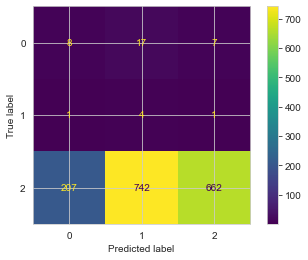

In [17]:
# multi-label plot ...
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df_validy, best_validation_data)
print(cm)
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

### Multi label stats
This function extracts Accuracy, Sensitivity, Specificity and Likelihood ratio for each of the 3 sentiment labels

In [22]:
accuracy, sensitivity, specificity, likelihood = contacts_utils.model_stats_all_labels(best_validation_data, df_validy)
print(f'Accuracy of model(<3, = 3, >3) is:   {np.round(accuracy*100, 2)}%')
print(f'Sensitivity of the test(<3, = 3, >3):{np.round(sensitivity*100,2)}%')
print(f'Specificity of the test(<3, = 3, >3):{np.round(specificity*100,2)}%')
print(f'Likelihood ratio(<3, = 3, >3):       {np.round(likelihood, 2)}')

Accuracy of model(<3, = 3, >3) is:   [85.93 53.85 41.96]%
Sensitivity of the test(<3, = 3, >3):[25.   66.67 41.09]%
Specificity of the test(<3, = 3, >3):[87.14 53.8  78.95]%
Likelihood ratio(<3, = 3, >3):       [1.94 1.44 1.95]


In [20]:
# We extract the best params from above cells
best_model_params = best_params

# Instead of joining validation data and train data, we simply reload the original data and split then into
# train and test. This is suboptimal, but being relatively fast, this is ok for now
validation_reqd = False
# we want the output to be onehot encoded and this makes it easier to use other activation functions
# other than softmax for the last layer, (as this is a multi-class classification problem)
oneh = True
trainX, trainy, testX, testy, validX, validy = contacts_utils.split_data(X, y, validation_reqd)
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# Now run the model with the best params
best_model_nn = create_svm_model(trainX, trainy, testX, testy)
st_ = timer()
# run NN model in parallel and extract results (train_score, valid_score,parameter, history of fit) as a list
b_train_score, b_val_score, b_param_dict, b_history, y_labels_predicted = best_model_nn(best_model_params)
end_ = timer()

accuracy, sensitivity, specificity, likelihood = contacts_utils.model_stats_all_labels(y_labels_predicted, testy)
print(f'Accuracy of model(<3, = 3, >3) is:   {np.round(accuracy*100, 2)}%')
print(f'Sensitivity of the test(<3, = 3, >3):{np.round(sensitivity*100,2)}%')
print(f'Specificity of the test(<3, = 3, >3):{np.round(specificity*100,2)}%')
print(f'Likelihood ratio(<3, = 3, >3):       {np.round(likelihood, 2)}')

Train: X=(6595, 18), y=(6595,)
Test: X=(2199, 18), y=(2199,)
Accuracy of model(<3, = 3, >3) is:[83.17 53.43 40.97]%
Sensitivity of the test(<3, = 3, >3):[30.12 72.22 38.85]%
Specificity of the test(<3, = 3, >3):[85.26 53.28 85.15]%
Likelihood ratio(<3, = 3, >3):[2.04 1.55 2.62]
